In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.SW_sqrt import psi_ln_sw
from operators.SW import solve_poisson_equation_two_stream, total_mass, total_momentum, total_energy_k

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mycolorpy import colorlist as mcp
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Bump-on-tail Instability SW

In [4]:
# set up configuration parameters
# number of mesh points in x
Nx = 101
# number of spectral expansions
Nv_e1 = 101
Nv_e2 = 101
Nv_i = 2
# epsilon displacement in initial electron distribution
epsilon = 0.03
# velocity scaling of electron and ion
alpha_e1 = 1
alpha_e2 = 0.5
alpha_i = np.sqrt(1 / 1863)
# x grid is from 0 to L
L = 20 * np.pi
# spacial spacing dx = x[i+1] - x[i]
dx = L / (Nx - 1)
# final time
T = 20
# velocity scaling
u_e1 = 0
u_e2 = 4.5
u_i = 0
# mass normalized
m_e1 = 1
m_e2 = 1
m_i = 1863
# charge normalized
q_e1 = -1
q_e2 = -1
q_i = 1

In [5]:
# velocity grid for plotting purposes
v = np.linspace(-8, 8, int(1e5))
# spatial grid 
x = np.linspace(0, L, Nx)

In [6]:
# load simulation data
sol_midpoint_u = np.load("../data/SW/bump_on_tail/sol_midpoint_u_" + str(Nv_e1) + ".npy")
sol_midpoint_t = np.load("../data/SW/bump_on_tail/sol_midpoint_t_" + str(Nv_e1) + ".npy")

# print shape of simulation data
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(20205, 2001)
(2001,)


In [7]:
# initialize the electric potential
E_midpoint = np.zeros((Nx, len(sol_midpoint_t)))

In [8]:
# initialize the states 
state_e1_midpoint = np.zeros((Nv_e1, Nx-1, len(sol_midpoint_t)))
state_e2_midpoint = np.zeros((Nv_e2, Nx-1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((Nv_i, Nx-1, len(sol_midpoint_t)))

for ii in range(len(sol_midpoint_t)):
    print(ii)
    for jj in range(Nv_e1):
        # unwind the flattening in order to solve the Vlasov-Poisson system
        state_e1_midpoint[jj, :, ii] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), ii]
        state_e2_midpoint[jj, :, ii] = sol_midpoint_u[Nv_e1*(Nx-1) + jj*(Nx-1): Nv_e1*(Nx-1) + (jj+1)*(Nx-1), ii]
    # static/background ions
    state_i_midpoint[0, :, ii] = (1 / (np.sqrt(2 * np.sqrt(np.pi)))) * np.ones(Nx-1) / alpha_i
    
    E_midpoint[:-1, ii] = solve_poisson_equation_two_stream(state_e1=state_e1_midpoint[:, :, ii],
                                                              state_e2=state_e2_midpoint[:, :, ii],
                                                              state_i=state_i_midpoint[:, :, ii],
                                                              alpha_e1=alpha_e1,
                                                              alpha_e2=alpha_e2,
                                                              alpha_i=alpha_i, 
                                                              dx=dx, 
                                                              Nx=Nx-1, 
                                                              Nv_e1=Nv_e1,
                                                              Nv_e2=Nv_e2, 
                                                              Nv_i=Nv_i, 
                                                              L=L)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

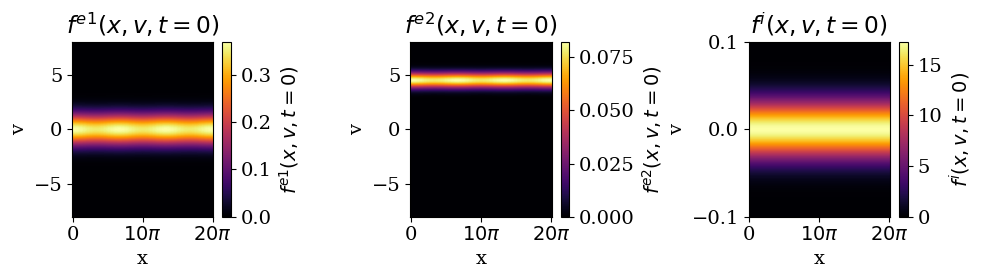

In [9]:
# plot initial condition
fig, ax = plt.subplots(ncols=3, sharey=False, figsize=(10, 3))
f_0e1 = np.outer(np.append(state_e1_midpoint[0, :, 0], state_e1_midpoint[0, 0, 0]), psi_ln_sw(xi=(v-u_e1)/alpha_e1, v=v, alpha_s=alpha_e1, u_s=u_e1, n=0))
pos = ax[0].pcolormesh(x, v, (f_0e1).T, cmap="inferno")
ax[0].set_xlabel("x")
ax[0].set_xticks([0, 10*np.pi, 20*np.pi])
ax[0].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[0].set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e1}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e1}(x, v, t=0)$")

f_0e2 = np.outer(np.append(state_e2_midpoint[0, :, 0], state_e2_midpoint[0, 0, 0]), psi_ln_sw(xi=(v-u_e2)/alpha_e2, v=v, alpha_s=alpha_e2, u_s=u_e2, n=0))
pos = ax[1].pcolormesh(x, v, (f_0e2).T, cmap="inferno")
ax[1].set_xticks([0, 10*np.pi, 20*np.pi])
ax[1].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[1].set_xlabel("x")
ax[1].set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e2}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{e2}(x, v, t=0)$")

f_0i = np.outer(np.append(state_i_midpoint[0, :, 0], state_i_midpoint[0, 0, 0]), psi_ln_sw(xi=(v-u_i)/alpha_i, v=v, alpha_s=alpha_i, u_s=u_i, n=0))
pos = ax[2].pcolormesh(x, v, (f_0i).T, cmap="inferno")
ax[2].set_xticks([0, 10*np.pi, 20*np.pi])
ax[2].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[2].set_xlabel("x")
ax[2].set_ylabel("v")
ax[2].set_yticks([-0.1, 0, 0.1])
ax[2].set_ylim(-0.1, 0.1)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[2].set_title("$f^{i}(x, v, t=0)$")

plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/initial_condition_bump_on_tail.png", dpi=600)

In [21]:
# compute the amplitude of the electric field wavelength k=1 for bump-on-tail
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

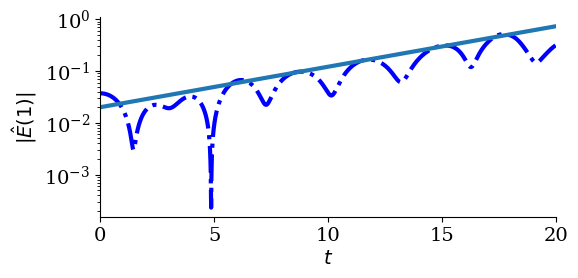

In [23]:
# plot growth rate
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "-.", c="blue", linewidth=3)
gamma = 0.18
ax.plot(sol_midpoint_t, np.exp(gamma*sol_midpoint_t)*2e-2, linewidth=3)

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/bump_on_tail_electric_growth_rate_"+ str(Nv_e1) + ".png", dpi=600)

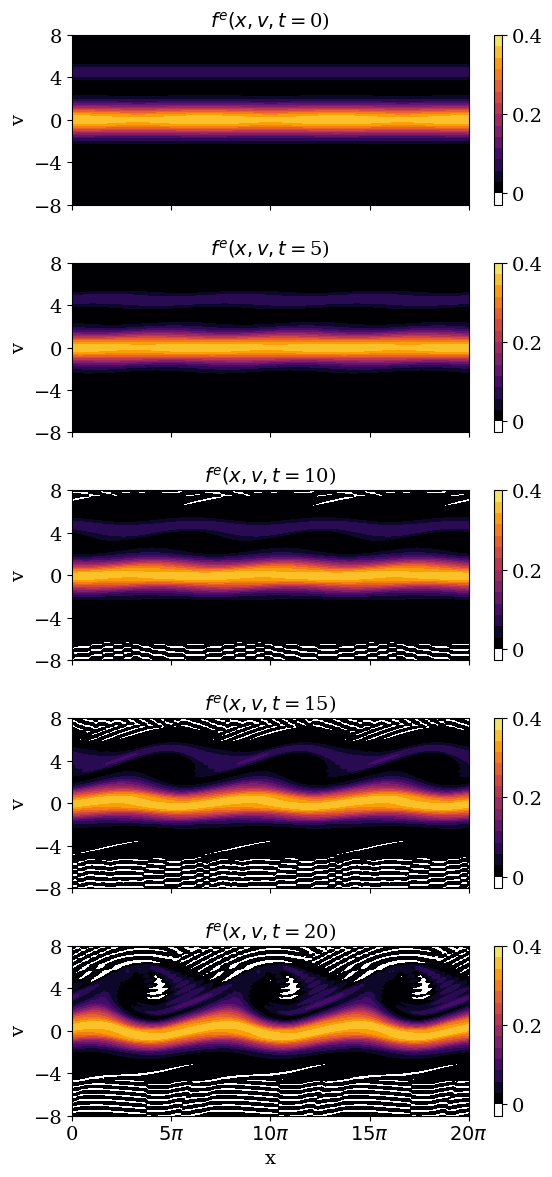

In [10]:
# plot phase space evolution as a function of time
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(6, 12))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)/4))):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv_e1):
        distribution += np.outer(np.append(state_e2_midpoint[jj, :, ii], state_e2_midpoint[jj, 0, ii]), psi_ln_sw(xi=(v-u_e2)/alpha_e2, v=v, alpha_s=alpha_e2, u_s=u_e2, n=jj))+ np.outer(np.append(state_e1_midpoint[jj, :, ii], state_e1_midpoint[jj, 0, ii]), psi_ln_sw(xi=(v-u_e1)/alpha_e1, v=v, alpha_s=alpha_e1, u_s=u_e1, n=jj))
    levels = np.append(-0.1, np.linspace(0, 0.4, 15))
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
    pos = ax[tt].contourf(x, v, (distribution).T, levels=levels, colors=np.append(["w"], colors))
    ax[tt].set_xticks([0, 5*np.pi, 10*np.pi, 15*np.pi, 20*np.pi])
    ax[tt].set_xticklabels([r"0", r"$5\pi$", r"$10\pi$", r"$15\pi$", r"$20\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_yticks([0, 0.2, 0.4])
    cbar.ax.set_yticklabels(["0", "0.2", "0.4"])
    ax[tt].set_yticks([-8, -4, 0, 4, 8])
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")", fontsize=14)
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/bump_on_tail_evolution_SW_" + str(Nv_e1) + ".png", dpi=600)

In [11]:
# save the electric field
np.save("../data/SW/bump_on_tail/sol_midpoint_E_" + str(Nv_e1)+ ".npy", E_midpoint)
np.save("../data/SW/bump_on_tail/sol_midpoint_state_e1_" + str(Nv_e1)+ ".npy", state_e1_midpoint)
np.save("../data/SW/bump_on_tail/sol_midpoint_state_e2_" + str(Nv_e2)+ ".npy", state_e2_midpoint)
np.save("../data/SW/bump_on_tail/sol_midpoint_state_i_" + str(Nv_i)+ ".npy", state_i_midpoint)

# conservation laws: mass, momentum, and energy

### mass conservation

In [20]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv_e1)\
                       +total_mass(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv_e2)\
                       +total_mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv_i)

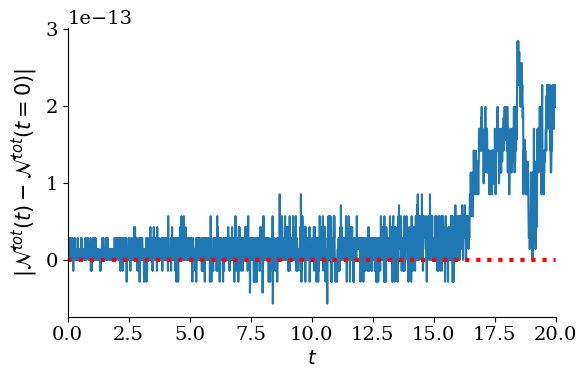

In [21]:
# plot mass evolution
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, (mass_midpoint - mass_midpoint[0]), "-")
ax.plot(sol_midpoint_t, (sol_midpoint_u[-1]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{N}(t)$")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
plt.tight_layout()

### momentum conservation

In [22]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv_e1, m_s=m_e1, u_s=u_e1)\
                           +total_momentum(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv_e2, m_s=m_e2, u_s=u_e2)\
                           +total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv_i, m_s=m_i, u_s=u_i)
    

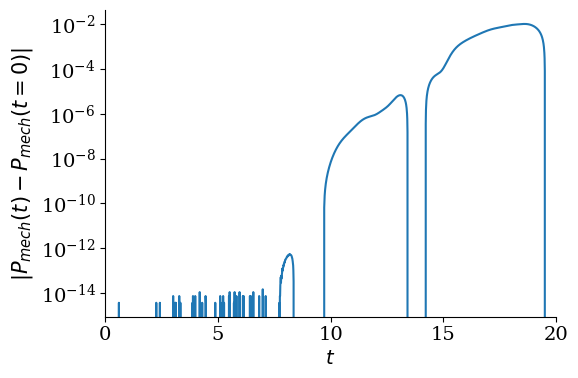

In [23]:
# plot momentum evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, (momentum_midpoint-momentum_midpoint[0]), "-")
ax.plot(sol_midpoint_t, (sol_midpoint_u[-3]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### energy conservation

In [16]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv_e1, m_s=m_e1, u_s=u_e1)\
                           +total_energy_k(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv_e2, m_s=m_e2, u_s=u_e2)\
                           +total_energy_k(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv_i, m_s=m_i, u_s=u_i)
    energy_p_midpoint[ii] = 0.5*dx*np.sum((E_midpoint[:-1, ii])**2)

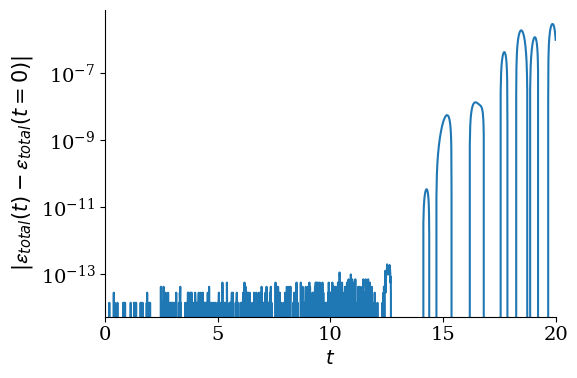

In [17]:
# plot energy evolution
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))
ax.plot(sol_midpoint_t, (energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.plot(sol_midpoint_t, (sol_midpoint_u[-5]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
plt.tight_layout()

In [18]:
sol_conservation = np.load("../data/SW/bump_on_tail/sol_midpoint_u_" + str(Nv_e1) + "_conservation.npy")

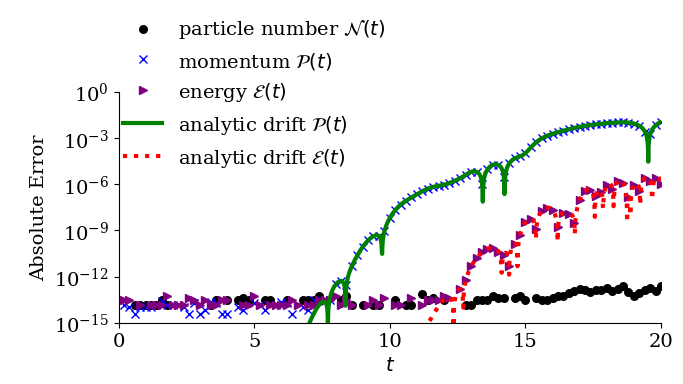

In [19]:
# plot overall conservation properties 
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))
ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
#ax.plot(sol_midpoint_t, np.abs(sol_conservation[-1]), "--", c="orange", linewidth=3, label=r"analytic drift $\mathcal{N}(t)$ ")
ax.plot(sol_midpoint_t, np.abs(sol_conservation[-2]), "-", c="green", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_conservation[-4]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")

ax.set_ylim(10**-15, 10**0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fontsize=14, loc='upper center', bbox_to_anchor=(0.25, 1.4))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/bump_on_tail/conservation_" + str(Nv_e1) + "_bump_on_tail_SW.png", bbox_inches='tight', dpi=600)